# Дипломная Работа

---

## Государтсвенный Университет Аэрокосмического Приборостроения (ГУАП).

---

## Прикладная Математика и Информатика

---

## Крючков Андрей Сергеевич, студент группы М811.


In [ ]:
!pip install geopandas

In [ ]:
from google.colab import drive 
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pandas as pd

from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class ModelVolterra:

  def __init__(self, data, name, choice):
    self.data = data.get(name)
    self.choice = choice
    self.name = name
    self.target = self.data[choice].tolist()
    self.consumption = self.data['total_consumption'].tolist()
    self.time = self.data['year'].tolist()
    self.r_score = 0

  def __relative_derivative(self, value):
    delta_time = [self.time[i+1]-self.time[i] if i == 0 
                        else self.time[i] - self.time[i-1] if i == len(self.time)-1
                        else self.time[i+1] - self.time[i-1] 
                        for i in range(len(self.time))]
    delta_data = [value[i+1]-value[i] if i == 0 
                        else value[i] - value[i-1] if i == len(value)-1
                        else value[i+1] - value[i-1] 
                        for i in range(len(value))]
    derivative_data = np.divide(delta_data, delta_time)
    relative_derivative_data = np.divide(derivative_data, value)
    return relative_derivative_data
  
  def __coefficient(self):
    ones_list = np.ones(len(self.data))
    consumption_list = self.data['total_consumption'].tolist()
    matrix = np.vstack((ones_list, self.target))
    matrix = np.vstack((matrix, consumption_list))
    matrix_transpose = matrix.transpose()
    first_tmp_matrix = matrix.dot(matrix_transpose)
    second_tmp_matrix = np.linalg.inv(first_tmp_matrix)
    relative_derivative_data = self.__relative_derivative(self.target).transpose()
    relative_derivative_consumption = self.__relative_derivative(self.consumption).transpose()
    third_tmp_matrix = matrix.dot(relative_derivative_data)
    fourth_tmp_matrix = matrix.dot(relative_derivative_consumption)
    first_coeff = second_tmp_matrix.dot(third_tmp_matrix)
    second_coeff =  second_tmp_matrix.dot(fourth_tmp_matrix)
    restored_data = [matrix_transpose[i].dot(first_coeff) for i in range(len(matrix_transpose))]
    restored_consumption = [matrix_transpose[i].dot(second_coeff) for i in range(len(matrix_transpose))]
    r_score_0 = r2_score(relative_derivative_data, restored_data)
    r_score_1 = r2_score(relative_derivative_consumption, restored_consumption)
    self.r_score = (r_score_1 + r_score_0)/2
    return first_coeff, second_coeff
  
  def __equation(self, y0, t, first_coeff, second_coeff):
    x, y = y0[0], y0[1]
    dxdt = (first_coeff[0] + first_coeff[1]*x + first_coeff[2]*y)*x 
    dydt = (second_coeff[0] + second_coeff[1]*y + second_coeff[2]*x)*y
    return np.array([dxdt, dydt], float)

  def __plot(self, solution, time):
    if self.choice == 'birth_rate':
      label = 'Рождаемость'
    if self.choice == 'death_rate':
      label = 'Смертность'
    if self.choice == 'npg':
      label = 'Прирост'
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=time, y=solution[:, 0],  name=label))
    fig.add_trace(go.Scatter(x=time, y=solution[:, 1], name='Потребление'))
    fig.update_layout(legend_orientation="h",
                      legend=dict(x=.5, xanchor="center"),
                      title="Потребление и естественный прирост",                  
                      hovermode="x",
                      margin=dict(l=0, r=0, t=0, b=0))
    fig.update_traces(hoverinfo="all", hovertemplate="Год: %{x}<br>Значение: %{y}")
    fig.show()

  def predict(self):
    first_coeff, second_coeff = self.__coefficient()
    t = np.arange(self.time[-1], 2025.2, 0.2)
    y0 = [self.target[-1], self.consumption[-1]]
    sol = odeint(self.__equation, y0, t, args=(first_coeff, second_coeff))
    print("R2 score: {}".format(self.r_score))
    self.__plot(sol, t)


In [ ]:
class ModelLotkaVolterra:

  def __init__(self, data, name, choice):
    self.data = data.get(name)
    self.choice = choice
    self.name = name
    self.r_score = 0
  
  def __relative_derivative(self, choice):
    data_list = self.data[choice].tolist()
    time_list = self.data['year'].tolist()
    delta_time = [time_list[i+1]-time_list[i] if i == 0 
                        else time_list[i] - time_list[i-1] if i == len(time_list)-1
                        else time_list[i+1] - time_list[i-1] 
                        for i in range(len(time_list))]
    delta_data = [data_list[i+1]-data_list[i] if i == 0 
                        else data_list[i] - data_list[i-1] if i == len(data_list)-1
                        else data_list[i+1] - data_list[i-1] 
                        for i in range(len(data_list))]
    derivative_data = np.divide(delta_data, delta_time)
    relative_derivative_data = np.divide(derivative_data, data_list)
    return relative_derivative_data

  def __coefficient(self, predator, victim):
    data_list = self.data[predator].tolist()
    ones_list = np.ones(len(data_list))
    matrix = np.vstack((ones_list,data_list))
    matrix_transpose = matrix.transpose()
    first_tmp_matrix = matrix.dot(matrix_transpose)
    second_tmp_matrix = np.linalg.inv(first_tmp_matrix)
    relative_derivative_data = self.__relative_derivative(victim).transpose()
    third_tmp_matrix = matrix.dot(relative_derivative_data)
    coefficient = second_tmp_matrix.dot(third_tmp_matrix)
    restored_data = [matrix_transpose[i].dot(coefficient) for i in range(len(matrix_transpose))]
    self.r_score += r2_score(relative_derivative_data, restored_data)
    return coefficient

  def __equation(self, y0, t, first_coeff, second_coeff):
    x, y = y0[0], y0[1]
    alpha, beta = first_coeff[0], first_coeff[1]
    gamma, delta = second_coeff[0], second_coeff[1]
    dxdt = alpha*x + beta*y*x
    dydt = gamma*y + delta*x*y
    return np.array([dxdt, dydt], float)

  def __plot(self, solution, time, choice):
    if choice == 'birth_rate':
      label = 'Рождаемость'
    if choice == 'death_rate':
      label = 'Смертность'
    if choice == 'npg':
      label = 'Прирост'
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=time, y=solution[:, 0],  name=label))
    fig.add_trace(go.Scatter(x=time, y=solution[:, 1], name='Потребление'))
    fig.update_layout(legend_orientation="h",
                      legend=dict(x=.5, xanchor="center"),
                      title="Потребление и естественный прирост",                  
                      hovermode="x",
                      margin=dict(l=0, r=0, t=0, b=0))
    fig.update_traces(hoverinfo="all", hovertemplate="Год: %{x}<br>Значение: %{y}")
    fig.show()

  def predict(self):
    choice = self.choice
    coeff_first = self.__coefficient(choice, 'total_consumption')
    coeff_second = self.__coefficient('total_consumption', choice)
    print("R2 Score: {}".format(self.r_score/2))
    if coeff_first[0] > 0 and coeff_first[1] < 0 and coeff_second[0] < 0 and coeff_second[1] > 0:
      t = np.arange(self.data['year'].tolist()[-1], 2025.2, 0.2)
      y0 = [self.data[choice].tolist()[-1], self.data['total_consumption'].tolist()[-1]]
      sol = odeint(self.__equation, y0, t, args=(coeff_first, coeff_second))
      print('{} - жертва, алкоголь - хищник'.format(choice))
      self.__plot(sol, t, choice)
    elif coeff_first[0] < 0 and coeff_first[1] > 0 and coeff_second[0] > 0 and coeff_second[1] < 0:
      t = np.arange(self.data['year'].tolist()[-1], 2025.2, 0.2)
      y0 = [self.data['total_consumption'].tolist()[-1], self.data[choice].tolist()[-1]]
      sol = odeint(self.__equation, y0, t, args=(coeff_second, coeff_first))
      print('алкоголья - жертва, {} - хищник'.format(choice))
      self.__plot(sol, t, choice)
    else:
      print('{}\nЭти данные не подходят к модели Лотки-Вольтерры\n'.format(self.name))

In [ ]:
data_alcohol = pd.read_csv('drive/MyDrive/data_graduate_work/russian_alcohol.csv', delimiter=',')
data_demography = pd.read_csv('drive/MyDrive/data_graduate_work/russian_demography.csv', delimiter=',')
data_demography = data_demography.query('year >= 1998 and year <= 2016')
data_demography.index = pd.RangeIndex(len(data_demography.index))
prepare_data = data_demography.merge(data_alcohol, on=["year", "region"])
filter = prepare_data['region'].isin(['Republic of Crimea', 'Chechen Republic', 'Sevastopol', 'Republic of Ingushetia']) 
index_list = prepare_data[filter].index.to_list()
prepare_data = prepare_data.drop(index = index_list)
prepare_data.index = pd.RangeIndex(len(prepare_data.index))

In [ ]:
index_list = data_alcohol[filter].index.to_list()
data_alcohol = data_alcohol.drop(index = index_list)
data_alcohol.index = pd.RangeIndex(len(data_alcohol.index))

In [ ]:
data_demography

,year,region,npg,birth_rate,death_rate,gdw,urbanization
0,1998,Republic of Adygea,-4.3,9.6,13.9,83.33,53.05
1,1998,Altai Krai,-4.0,8.8,12.8,72.67,52.76
2,1998,Amur Oblast,-1.8,10.4,12.2,65.59,66.07
3,1998,Arkhangelsk Oblast,-4.2,9.1,13.3,68.28,74.30
4,1998,Astrakhan Oblast,-3.7,9.6,13.3,73.76,68.13
...,...,...,...,...,...,...,...
1610,2016,Chuvash Republic,0.0,13.2,13.2,74.05,61.30
1611,2016,Chukotka Autonomous Okrug,3.6,13.6,10.0,56.18,69.20
1612,2016,Sakha (Yakutia) Republic,7.6,16.0,8.4,67.83,65.40
1613,2016,Yamalo-Nenets Autonomous Okrug,10.1,15.4,5.3,51.10,83.70


# Графики по алкоголю


In [ ]:
data_alcohol.describe()

,year,wine,beer,vodka,champagne,brandy
count,1539.000000,1539.000000,1539.000000,1539.000000,1539.000000,1539.000000
mean,2007.000000,5.637544,51.722190,11.902404,1.315172,0.524185
std,5.479006,2.811555,25.115577,5.078808,0.798462,0.399331
min,1998.000000,0.100000,1.000000,0.400000,0.100000,0.000000
25%,2002.000000,3.550000,32.700000,8.400000,0.800000,0.200000
50%,2007.000000,5.400000,50.300000,11.600000,1.200000,0.400000
75%,2012.000000,7.400000,67.500000,15.000000,1.660000,0.700000
max,2016.000000,18.100000,207.300000,40.600000,5.560000,2.300000


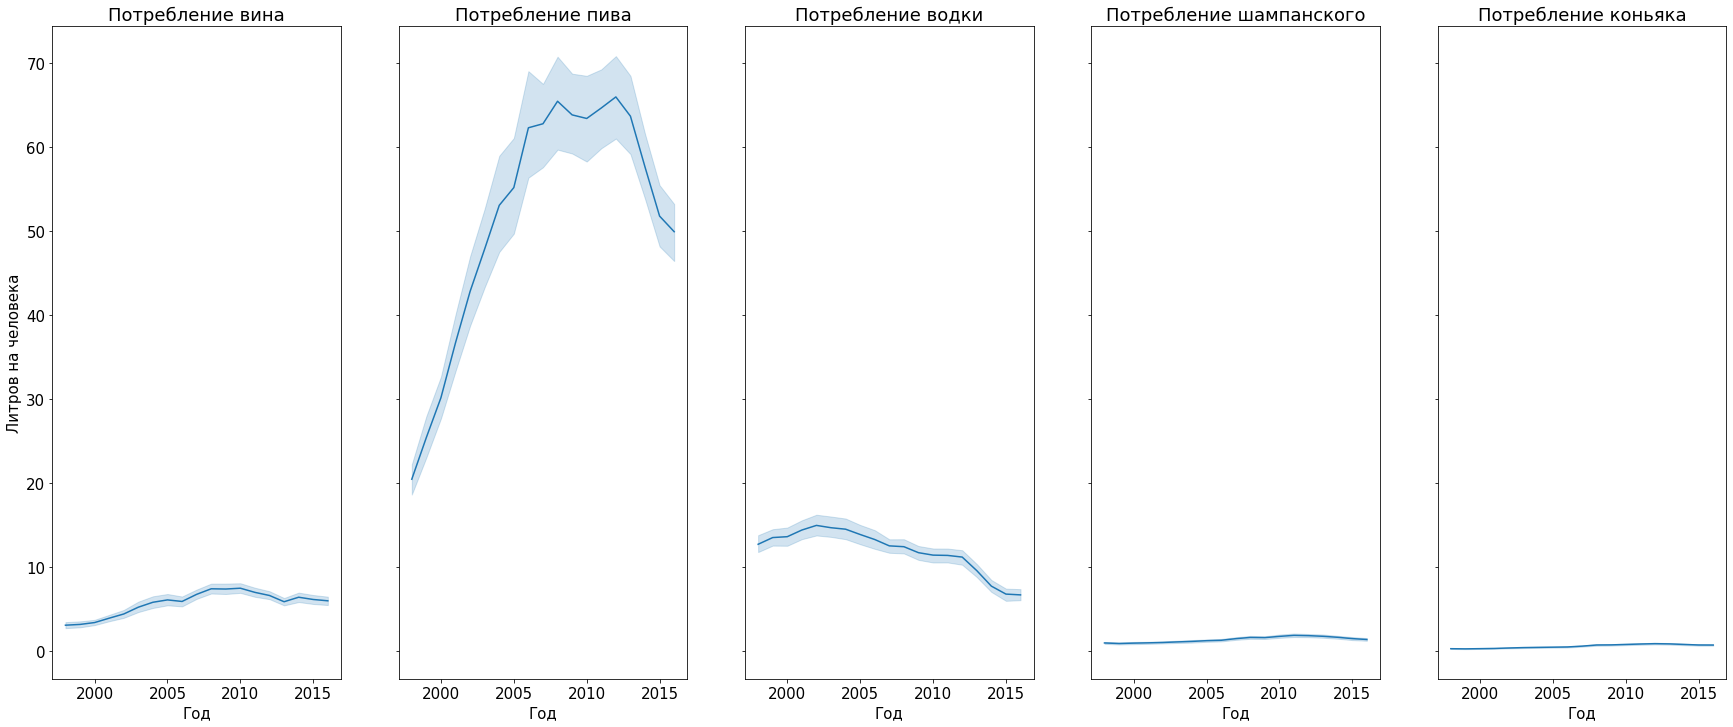

In [ ]:
plt.rcParams['font.size'] = '15'

fig, axes = plt.subplots(1, 5, figsize=(30, 12), sharey=True)
columns_name = ['вина', 'пива', 'водки', 'шампанского', 'коньяка']
for x in range(1, 6, 1):
    sns.lineplot(data=data_alcohol, x="year", y=f"{data_alcohol.columns[x + 1]}", ax=axes[x - 1])
    axes[x - 1].set_title(f"Потребление {columns_name[x-1]}")
    axes[x - 1].set_xlabel("Год")
    axes[x - 1].set_ylabel("Литров на человека")

In [ ]:
mean_cons_in_regions = data_alcohol.groupby('region', as_index=False).agg({'vodka':'median', 'wine':'median', 'beer':'median', 'champagne':'median', 'brandy':'median'})

In [ ]:
data=mean_cons_in_regions.sort_values(by='champagne',ascending=False)[:10]
data

,region,vodka,wine,beer,champagne,brandy
32,Moscow,18.90,6.8,87.8,4.2,1.20
16,Kamchatka Krai,18.60,7.4,69.6,3.3,1.40
30,Magadan Oblast,17.80,6.8,42.0,3.1,0.90
58,Saint Petersburg,12.50,7.1,101.0,2.5,1.13
34,Murmansk Oblast,17.70,8.1,49.3,2.2,0.90
33,Moscow Oblast,15.20,7.3,67.4,2.2,1.30
60,Sakhalin Oblast,18.80,6.9,52.2,2.2,1.10
28,Leningrad Oblast,15.38,8.5,66.7,2.1,1.10
19,Khabarovsk Krai,15.50,5.0,73.7,2.1,0.70
8,Chukotka Autonomous Okrug,12.40,4.0,12.3,1.9,1.10


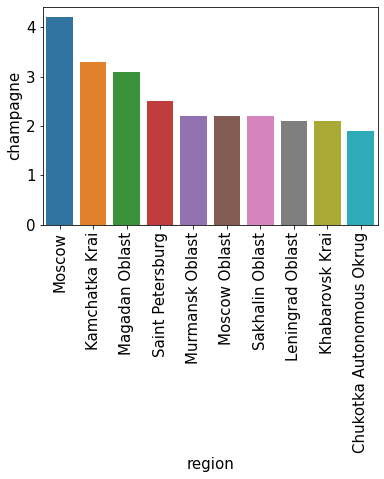

In [ ]:
plt.rcParams['font.size'] = '15'
ch=sns.barplot(data=mean_cons_in_regions.sort_values(by='champagne',ascending=False)[:10], x='region', y='champagne')
ch = ch.set_xticklabels(ch.get_xticklabels(), rotation=90)

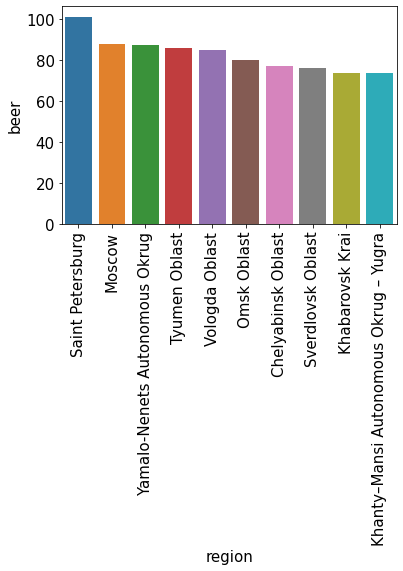

In [ ]:
b=sns.barplot(data=mean_cons_in_regions.sort_values(by='beer',ascending=False)[:10], x='region', y='beer')
b = b.set_xticklabels(b.get_xticklabels(), rotation=90)

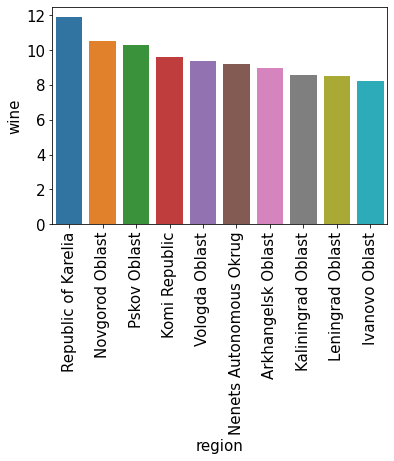

In [ ]:
w=sns.barplot(data=mean_cons_in_regions.sort_values(by='wine',ascending=False)[:10], x='region', y='wine')
w = w.set_xticklabels(w.get_xticklabels(), rotation=90)

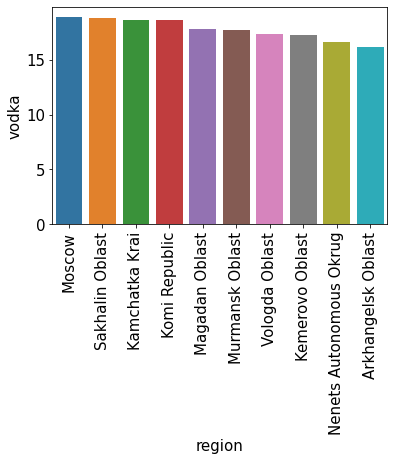

In [ ]:
v=sns.barplot(data=mean_cons_in_regions.sort_values(by='vodka',ascending=False)[:10], x='region', y='vodka')
v = v.set_xticklabels(v.get_xticklabels(), rotation=90)

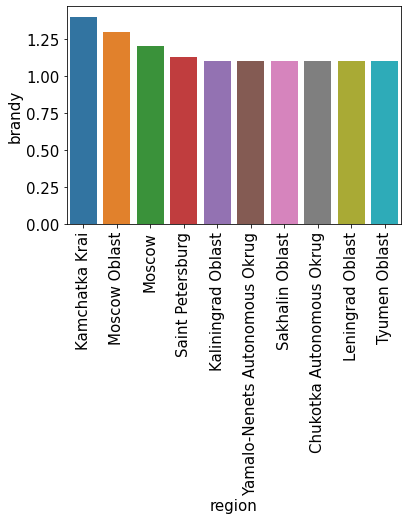

In [ ]:
br=sns.barplot(data=mean_cons_in_regions.sort_values(by='brandy',ascending=False)[:10], x='region', y='brandy')
br = br.set_xticklabels(br.get_xticklabels(), rotation=90)

# Графики по демографии

In [ ]:
dfTopBirth = prepare_data.groupby(['region']).agg({'npg':'mean', 'birth_rate':'mean','death_rate':'mean'}).sort_values(by="birth_rate", ascending=False)
dfTopBirth

,npg,birth_rate,death_rate
region,,,
Tuva Republic,9.773684,22.026316,12.347368
Altai Republic,5.505263,18.242105,12.810526
Republic of Dagestan,11.226316,17.163158,5.894737
Sakha (Yakutia) Republic,6.105263,15.657895,9.542105
Nenets Autonomous Okrug,3.921053,15.478947,11.563158
...,...,...,...
Ryazan Oblast,-9.010526,9.226316,18.200000
Republic of Mordovia,-6.542105,9.000000,15.494737
Tambov Oblast,-8.926316,8.821053,17.689474


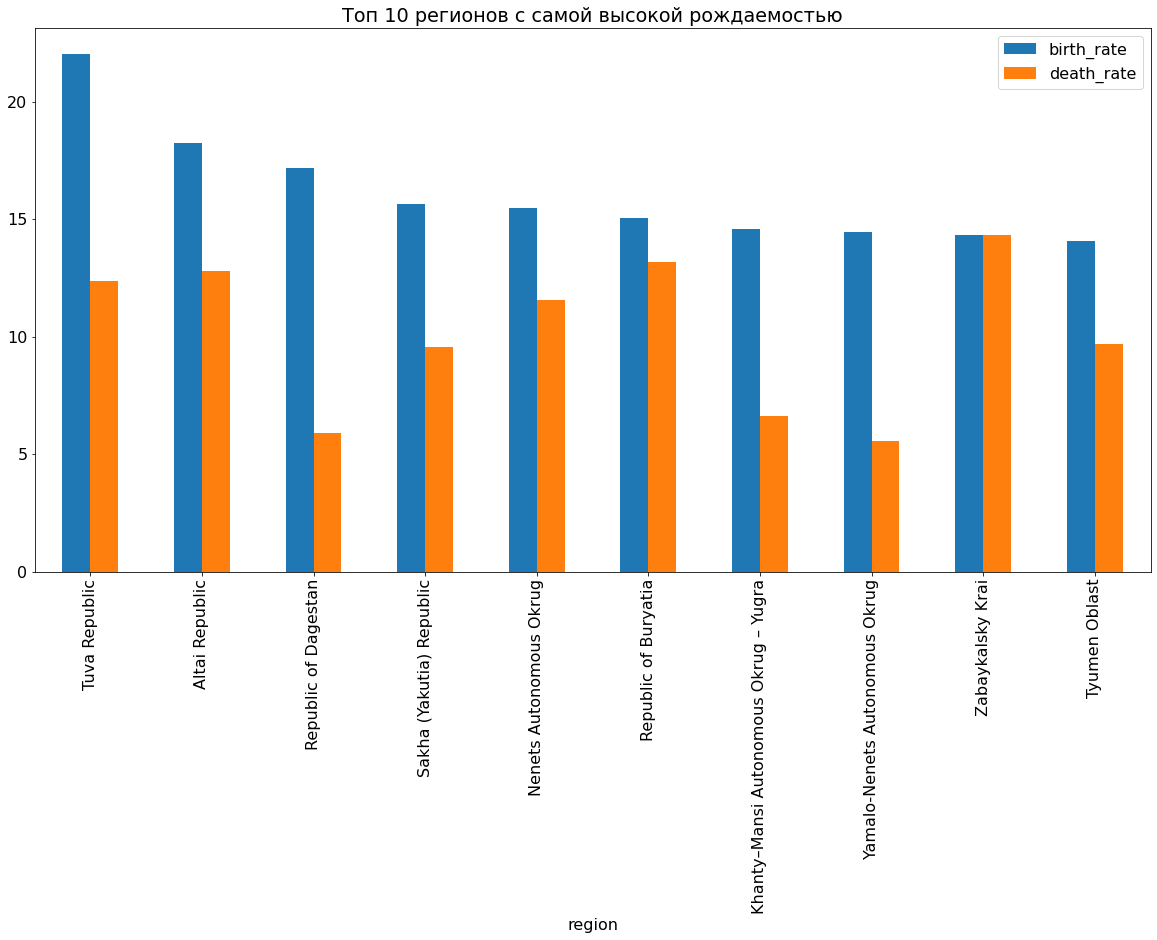

In [ ]:
plt.rcParams['font.size'] = '16'
dfTopBirth = prepare_data.groupby(['region']).agg({'birth_rate':'mean','death_rate':'mean'}).sort_values(by="birth_rate", ascending=False).head(10)

dfTopBirth.plot.bar(figsize=(20,10),title='Топ 10 регионов с самой высокой рождаемостью')
plt.show()

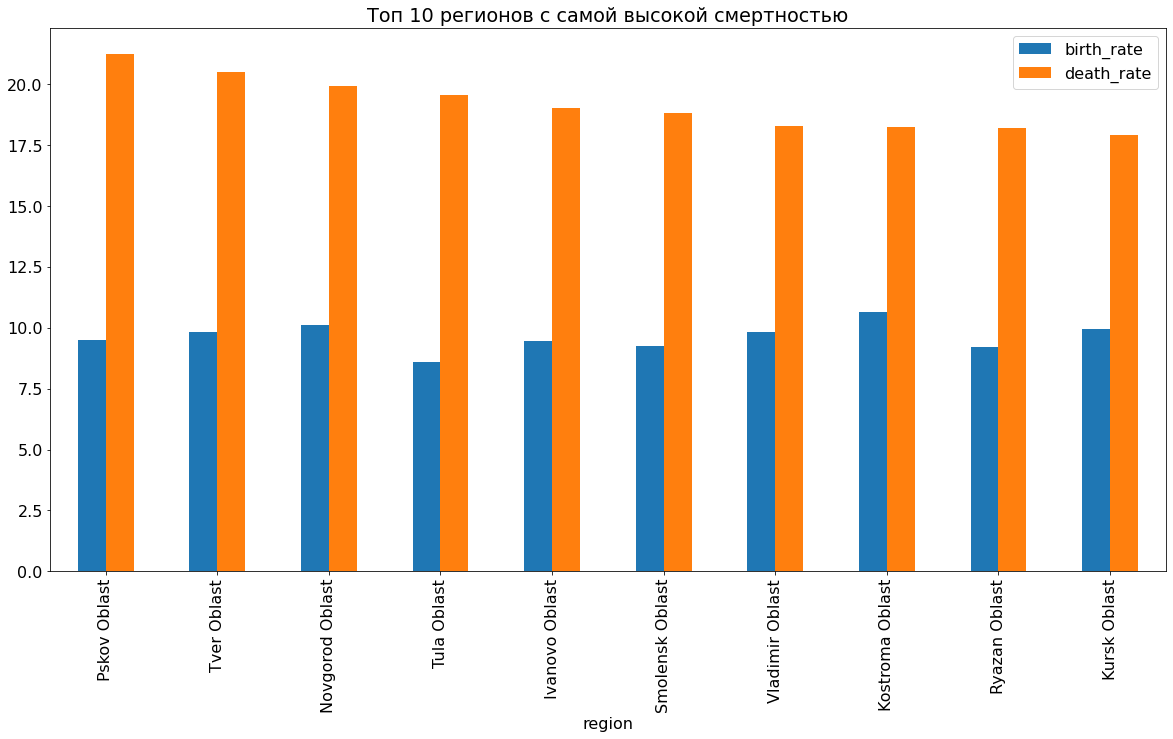

In [ ]:
plt.rcParams['font.size'] = '16'
dfTopDeatch = prepare_data.groupby(['region']).agg({'birth_rate':'mean','death_rate':'mean'}).sort_values(by="death_rate", ascending=False).head(10)

dfTopDeatch.plot.bar(figsize=(20,10),title='Топ 10 регионов с самой высокой смертностью')
plt.show()

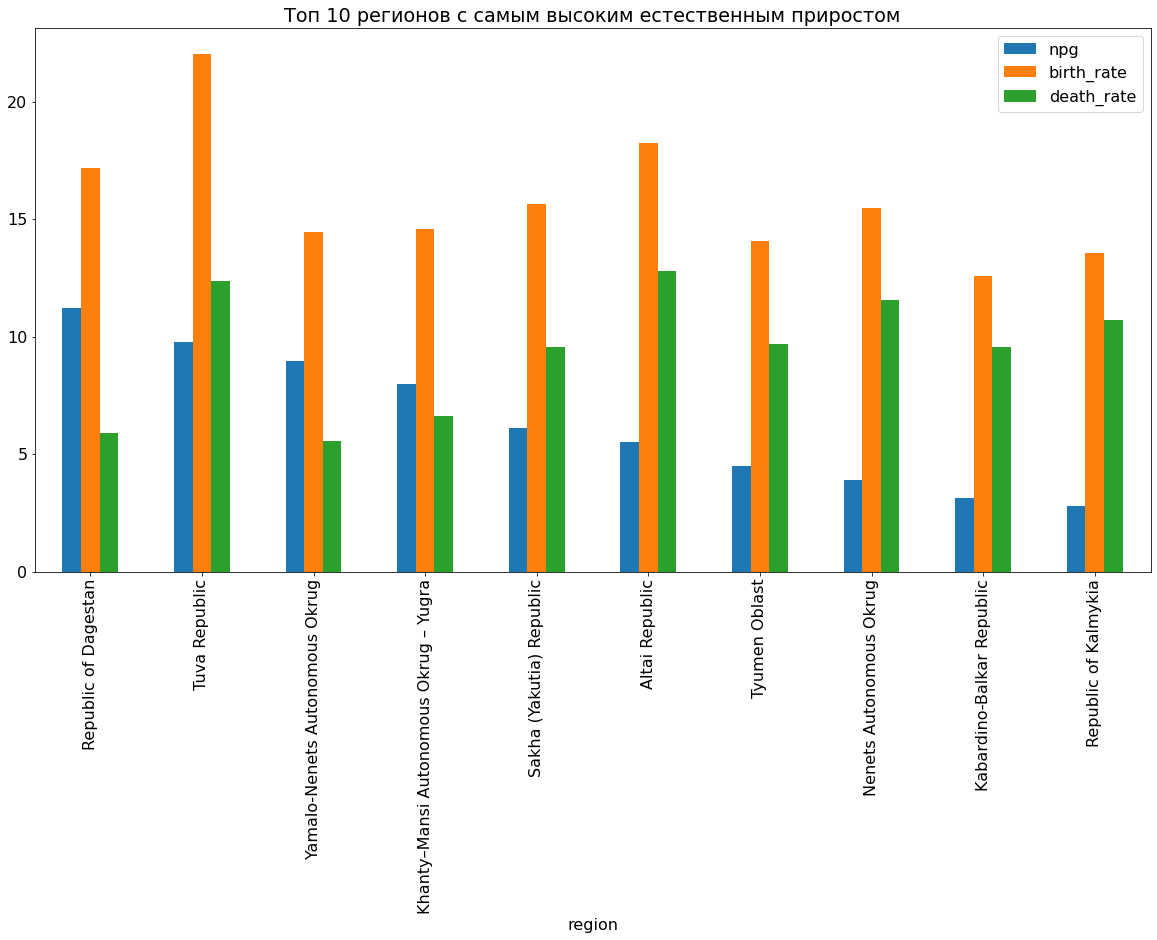

In [ ]:
plt.rcParams['font.size'] = '16'
dfTopNPG = prepare_data.groupby(['region']).agg({'npg':'mean', 'birth_rate':'mean','death_rate':'mean'}).sort_values(by="npg", ascending=False).head(10)
dfTopNPG.plot.bar(figsize=(20,10),title='Топ 10 регионов с самым высоким естественным приростом')
plt.show()

# Регрессия для рождаемости по всей России

In [ ]:
date_list = prepare_data['year'].unique().tolist()
data = []
for i in date_list:
  filter_year = prepare_data['year'].isin([i])
  tmp_region_df = prepare_data[filter_year]
  tmp_region_df = tmp_region_df.drop(columns=['year', 'region'])
  tmp = tmp_region_df.sum()
  tmp['gdw'] = tmp['gdw']/len(prepare_data['region'].unique().tolist())
  tmp['urbanization'] = tmp['urbanization']/len(prepare_data['region'].unique().tolist())
  tmp['year'] = int(i)
  data.append(tmp.to_dict())

In [ ]:
df = pd.DataFrame(data)
df['total_consumption'] = df['wine']*0.115 + df['champagne']*0.105 + (df['brandy'] + df['vodka'])*0.4 + df['beer']*0.045
df['total_consumption'] = df['total_consumption']/len(prepare_data['region'].unique().tolist())

In [ ]:
df

,npg,birth_rate,death_rate,gdw,urbanization,wine,beer,vodka,champagne,brandy,year,total_consumption
0,-313.2,758.2,1071.4,72.707037,69.597284,245.40,1654.00,1026.2,74.00,18.54,1998.0,6.522432
1,-450.5,714.6,1165.1,70.625802,69.709753,252.80,2057.00,1091.0,68.60,17.08,1999.0,7.062617
2,-475.5,743.0,1218.5,68.144691,69.625062,270.80,2440.60,1099.4,72.30,18.93,2000.0,7.356698
3,-475.4,775.2,1250.6,65.898272,69.716790,313.00,2970.70,1163.6,75.10,21.10,2001.0,8.042494
4,-478.7,829.1,1307.8,64.357284,69.834074,353.50,3466.10,1208.3,78.50,25.50,2002.0,8.622093
5,-472.8,864.3,1337.4,62.247160,69.941111,419.10,3875.80,1185.9,84.10,29.30,2003.0,8.858247
6,-424.0,881.9,1307.0,60.184568,69.853086,466.60,4296.70,1171.8,88.90,31.40,2004.0,9.106481
7,-464.3,859.1,1325.5,59.009259,69.574074,489.40,4468.00,1120.5,96.00,33.30,2005.0,8.999272
8,-371.0,871.9,1245.4,58.170494,69.565432,474.40,5045.10,1072.1,99.70,35.40,2006.0,9.074741
9,-234.7,956.7,1193.8,57.917654,69.677778,543.00,5083.90,1010.8,115.20,43.30,2007.0,8.950080


In [ ]:
df_1 = df

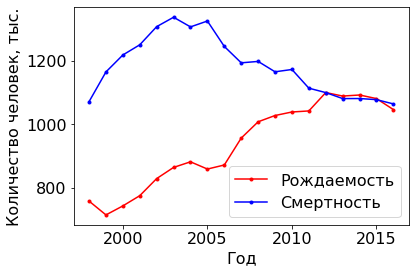

In [ ]:
# plt.rcParams['figure.figsize'] = [14, 10]
plt.plot(df.year, df.birth_rate, marker='.', color='red', label='Рождаемость')
plt.plot(df.year, df.death_rate, marker='.', color='blue', label='Смертность')
plt.ylabel('Количество человек, тыс.')
plt.xlabel('Год')
# plt.plot(df.year, df.npg, marker='.', color='green', label='Припрост')
# plt.plot(df.year, np.zeros(len(df.npg)), color='black', label='Нулевой прирост')
plt.legend()

Text(0, 0.5, 'Потребление')

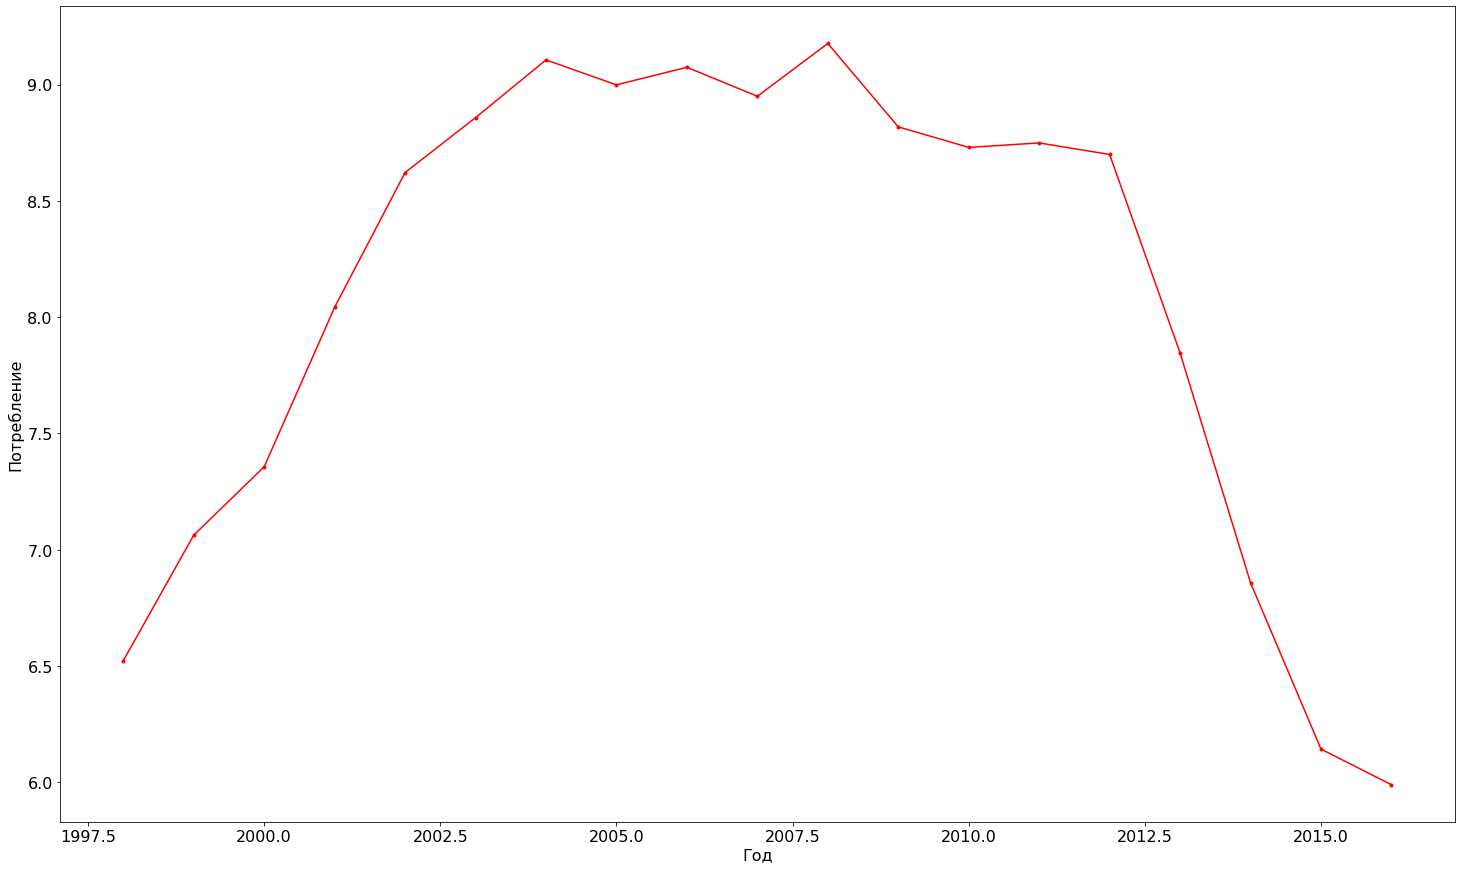

In [ ]:
plt.rcParams['figure.figsize'] = [25, 15]
plt.plot(df.year, df.total_consumption, marker='.', color='red', label='Потребление')
# plt.plot(df.year, df.npg, marker='.', color='green', label='Припрост')
plt.xlabel('Год')
plt.ylabel('Потребление')
# plt.legend()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.year, y=df.npg,  name='Прирост'))
fig.add_trace(go.Scatter(x=df.year, y=df.total_consumption, name='Потребление'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title="Потребление и естественный прирост",                  
                  hovermode="x",
                  margin=dict(l=0, r=0, t=0, b=0))
fig.update_traces(hoverinfo="all", hovertemplate="Год: %{x}<br>Значение: %{y}")
fig.show()

In [ ]:
target = df['birth_rate']

In [ ]:
df.drop(columns=['birth_rate', 'year', 'npg','wine', 'champagne', 'brandy', 'vodka', 'beer'], 
        inplace=True)

In [ ]:
scaler = StandardScaler()
scaler.fit(df) 
scaled_df = scaler.transform(df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, 
                                                    target.to_list(), 
                                                    test_size=0.2, 
                                                    random_state=42)

In [ ]:
clf = Ridge()
clf.fit(X_train, y_train)

train_predictions = clf.predict(X_train) 
test_predictions = clf.predict(X_test)

print("Train MAPE: {}".format((1 - mean_absolute_percentage_error(y_train, train_predictions))*100))
print("Test MAPE: {}".format((1 - mean_absolute_percentage_error(y_test, test_predictions))*100))
print("Test R2: {}".format(r2_score(y_test, test_predictions)))

Train MAPE: 96.08305691784447
Test MAPE: 85.75859016493767
Test R2: -0.19239951972353397


In [ ]:
sgdr_regression_model = SGDRegressor(tol= .001, eta0=.01) 
sgdr_regression_model.fit(X_train, y_train)

train_predictions = sgdr_regression_model.predict(X_train) 
test_predictions = sgdr_regression_model.predict(X_test)

print("Train MAPE: {}".format((1 - mean_absolute_percentage_error(y_train, train_predictions))*100))
print("Test MAPE: {}".format((1 - mean_absolute_percentage_error(y_test, test_predictions))*100))
print("Test R2: {}".format(r2_score(y_test, test_predictions)))

Train MAPE: -352713762895668.94
Test MAPE: -400376066236120.1
Test R2: -7.590758901630488e+26


# Моделирование рождаемости/смертности по регионам России

In [ ]:
region_list = prepare_data['region'].unique().tolist()
region_dict = {}
for i in region_list:
  filter_year = prepare_data['region'].isin([i])
  tmp_region_df = prepare_data[filter_year]
  tmp_region_df = tmp_region_df.drop(columns=['region'])
  tmp_region_df['total_consumption'] = tmp_region_df['wine']*0.115 + tmp_region_df['champagne']*0.105 + (tmp_region_df['brandy'] + tmp_region_df['vodka'])*0.4 + tmp_region_df['beer']*0.045
  region_dict.update({i: tmp_region_df})

In [ ]:
keys = ['Moscow', 'Saint Petersburg']
for key in keys:
  mv = ModelVolterra(data=region_dict, name=key, choice='birth_rate')
  print(key)
  mv.predict()

Moscow
R2 score: 0.5122976998747476


Saint Petersburg
R2 score: 0.5516591216472883


In [ ]:
for key in keys:
  mv = ModelVolterra(data=region_dict, name=key, choice='death_rate')
  print(key)
  mv.predict()

Moscow
R2 score: 0.6084891410031728


Saint Petersburg
R2 score: 0.49195480329726593


/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



In [ ]:
for key in keys:
  mlv = ModelLotkaVolterra(data=region_dict, name=key, choice='birth_rate')
  print(key)
  mlv.predict()

Moscow
R2 Score: 0.5010191405475879
birth_rate - жертва, алкоголь - хищник


Saint Petersburg
R2 Score: 0.47314060144913545
birth_rate - жертва, алкоголь - хищник


In [ ]:
for key in keys:
  mlv = ModelLotkaVolterra(data=region_dict, name=key, choice='death_rate')
  print(key)
  mlv.predict()

Moscow
R2 Score: 0.6048345784712701
алкоголья - жертва, death_rate - хищник


Saint Petersburg
R2 Score: 0.21877563928481186
алкоголья - жертва, death_rate - хищник


Moscow Oblast
R2 Score: 0.5948329704397963
алкоголья - жертва, death_rate - хищник


Krasnodar Krai
R2 Score: 0.21883735869287763
алкоголья - жертва, death_rate - хищник


Sverdlovsk Oblast
R2 Score: 0.5445726624799845
алкоголья - жертва, death_rate - хищник


Rostov Oblast
R2 Score: 0.01917670878382083
Rostov Oblast
Эти данные не подходят к модели Лотки-Вольтерры

Republic of Tatarstan
R2 Score: 0.24008007899605993
алкоголья - жертва, death_rate - хищник


# Корреляция

In [ ]:
def heatmap_correlation(data, name):
  plt.figure(figsize = (20,15))
  heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, 
                        annot=True, cbar=False, cmap= 'coolwarm', linewidths=3,
                        linecolor='black')
  heatmap.set_title('Correlation Heatmap {}'.format(name), fontdict={'fontsize':18}, pad=12);

In [ ]:
df_1.drop(columns=['gdw', 'urbanization'], inplace=True)

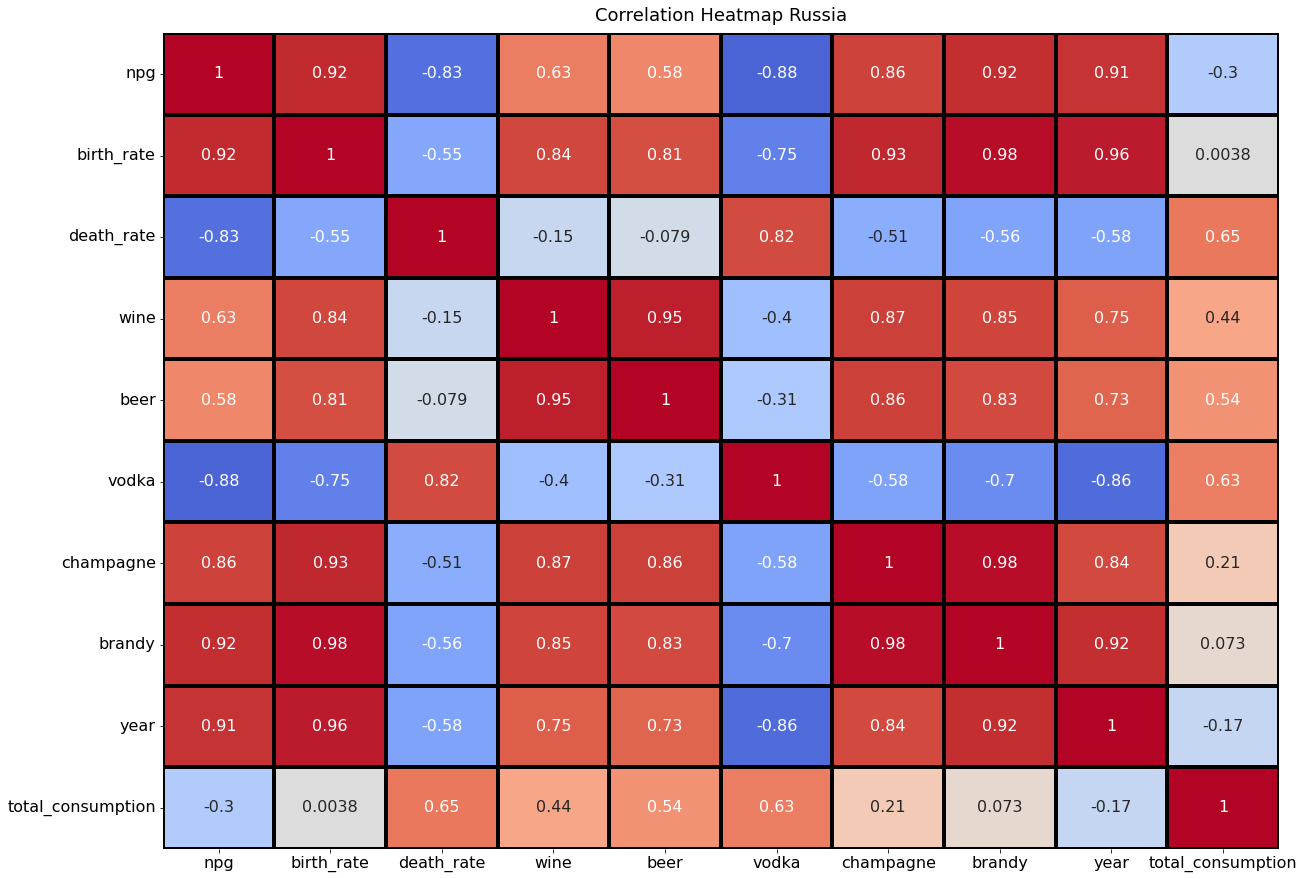

In [ ]:
heatmap_correlation(df_1, 'Russia')